In [1]:
# assign directory
import git
from pathlib import Path
import os
ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
os.chdir(os.path.join(ROOT_DIR, "utilities"))
# from transform import *
from transform_audio import *
# from plotting import *
os.chdir(os.path.join(ROOT_DIR, "dataset-preparation"))

data_dir  = os.path.join(ROOT_DIR, 'raw-data', 'ravdess', 'full-ravdess-wav-processed')
# iterate over files in that directory
file_list = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename != ".DS_Store"]
file_names = os.listdir(data_dir)

In [8]:
max_n = max(map(lambda p: len(wavfile.read(p)[1]), file_list))
max_n

160256

In [9]:
transform_list(fft_file, file_list, file_names, n=max_n)

Computing and exporting coefficients:   0%|          | 0/1440 [00:00<?, ?it/s]

# Fourier Representation

In [6]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
from scipy.io import wavfile
import librosa

In [7]:
ravdess_df = pd.read_csv(os.path.join(ROOT_DIR, "raw-data", "ravdess", 'full-ravdess.csv'))

In [8]:
test_file_idx = 42
print(ravdess_df.iloc[test_file_idx])

rate, signal1 = wavfile.read(file_list[test_file_idx])
signal2, rate_l = librosa.load(file_list[test_file_idx], sr=None)

Unnamed: 0                                           42
modality                                     audio-only
channel                                          speech
emotion                                         neutral
intensity                                        normal
statement                  Kids are talking by the door
repetition                                            2
actor                                                19
sex                                                male
filename                       03-01-01-01-01-02-19.wav
length (s)                                        1.344
rate (Hz)                                         48000
amplitudes    [ 2012  1486   232 ... -6685 -6556 -7419]
Name: 42, dtype: object


In [9]:
print(rate == rate_l)
print(signal1 / signal2)
# just scaled down by 2**15 (normalized by maximumum signal)
signal = signal2

True
[32768. 32768. 32768. ... 32768. 32768. 32768.]


C:\Users\Henry\AppData\Local\Temp\ipykernel_37832\1270320814.py:2: RuntimeWarning: invalid value encountered in divide
  print(signal1 / signal2)


In [10]:
fft_signal = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(signal), 1/rate)

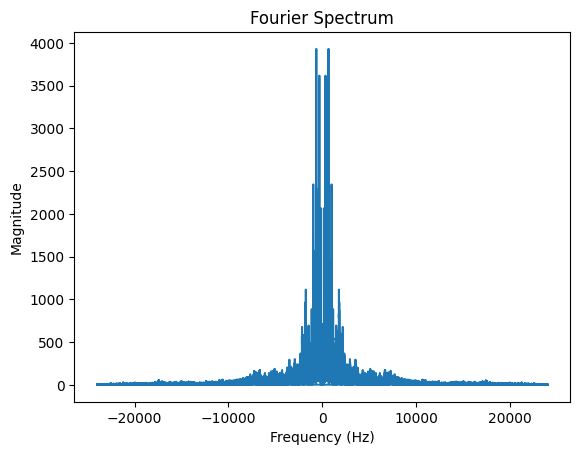

In [11]:
plt.plot(frequencies, np.abs(fft_signal))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Fourier Spectrum')
plt.show()

In [12]:
negative_idx = len(frequencies) // 2 # first half nonnegative, second half negative
assert negative_idx == (frequencies < 0).argmax()
assert (frequencies[1:negative_idx] == -frequencies[negative_idx + 1:][::-1]).all() # exclude one negative due to parity mismatch
positive_signals = fft_signal[1:negative_idx]
negative_signals = fft_signal[negative_idx + 1:][::-1]
assert ((positive_signals + negative_signals).imag == 0).all() # all real
print(positive_signals)
print(negative_signals)

[ 166.45377  +452.9518j       89.94155  -233.22443j
 -490.63513  +108.84839j    ...   -0.9668803  +2.7040968j
    1.1774989  +0.69995975j    3.9380465  -0.6990689j ]
[ 166.45377  -452.9518j       89.94155  +233.22443j
 -490.63513  -108.84839j    ...   -0.9668803  -2.7040968j
    1.1774989  -0.69995975j    3.9380465  +0.6990689j ]


In [13]:
def fft_file(filename, visualize=False, title='Fourier Spectrum'):
    rate, signal = librosa.load(os.path.join(data_dir, filename), sr=None)
    fft_signal = np.fft.fft(signal)
    frequencies = np.fft.fftfreq(len(signal), 1/rate)

    if visualize:
        plt.plot(frequencies, np.abs(fft_signal))
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.title(title)
        plt.show()
    
    return fft_signal, frequencies

## Frequency band grouping

In [3]:
bands = freq_band_groupings(
    coefs_npz_path='/Users/benrabin/Archive/ravdess-transforms/fourier/fft_coefs.npz',
    freqs_npy_path='/Users/benrabin/Archive/ravdess-transforms/fourier/fft_freqs.npy',
    ks_threshold=0.05
)

In [4]:
freqs = np.load('/Users/benrabin/Archive/ravdess-transforms/fourier/fft_freqs.npy')

In [5]:
gaps = [freqs[band[1]] - freqs[band[0]] for band in bands[:-1]]

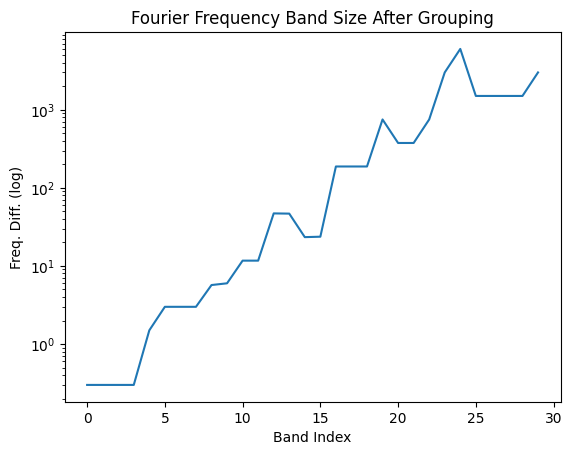

In [6]:
plt.plot(gaps)
plt.yscale('log')
plt.xlabel('Band Index')
plt.ylabel('Freq. Diff. (log)')
plt.title('Fourier Frequency Band Size After Grouping')
plt.show()

In [7]:
from sklearn import linear_model

In [8]:
model = linear_model.LinearRegression()
x = np.arange(len(gaps)).reshape(-1, 1)
y = np.log(gaps)
model.fit(x, y)
log_pred_gaps = model.predict(x)
pred_gaps = np.exp(log_pred_gaps)

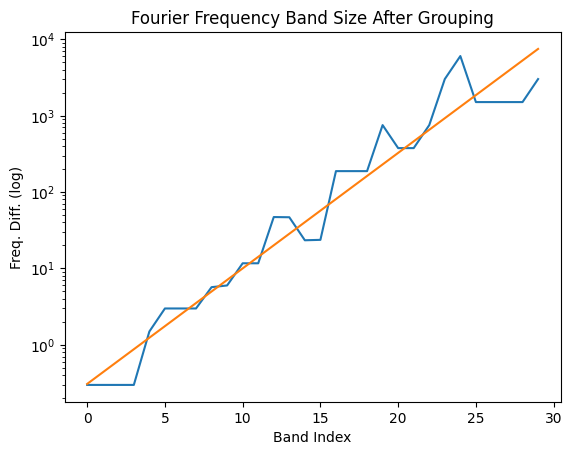

In [9]:
plt.plot(gaps)
plt.plot(pred_gaps)
plt.yscale('log')
plt.xlabel('Band Index')
plt.ylabel('Freq. Diff. (log)')
plt.title('Fourier Frequency Band Size After Grouping')
plt.show()

$$\log(g_i) = \theta_0 + \theta_1 i \\
g_i = e^{\theta_0} e^{\theta_1 i} = \alpha \cdot \beta^i$$

In [13]:
model.intercept_, model.coef_ # theta_0, theta_1

(np.float64(-1.175041884674469), array([0.34790649]))

In [14]:
np.exp(model.intercept_), np.exp(model.coef_[0]) # alpha, beta

(np.float64(0.30880604517646654), np.float64(1.4160998293943505))

In [15]:
.3088 * 1.416**10, pred_gaps[10]

(10.007136534192295, np.float64(10.014389944033711))

In [12]:
pred_freqs = np.cumsum(np.append(freqs[0], pred_gaps))
pred_freqs

array([0.00000000e+00, 3.08806045e-01, 7.46106233e-01, 1.36536695e+00,
       2.24230196e+00, 3.48412946e+00, 5.24268118e+00, 7.73296598e+00,
       1.12594578e+01, 1.62533224e+01, 2.33251331e+01, 3.33395230e+01,
       4.75208989e+01, 6.76031429e+01, 9.60416052e+01, 1.36313307e+02,
       1.93342056e+02, 2.74100459e+02, 3.88462420e+02, 5.50410372e+02,
       7.79744840e+02, 1.10450534e+03, 1.56439863e+03, 2.21565344e+03,
       3.13789527e+03, 4.44388176e+03, 6.29328900e+03, 8.91223429e+03,
       1.26209223e+04, 1.78727947e+04, 2.53099703e+04])